# Neurons Analysis

Dataset: Neurons (Steinmetz)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from app.dataset.steinmetz import load_data
from app.explore.summary import session_accuracy_report
from app.explore.neurons import plot_firing_rate, plot_spikes_raster, reduce_dimensionality, plot_components
from app.utils.util import filter_neurons_by_brain_area, filter_neurons_by_brain_region, sort_neurons_by_brain_region, filter_trials

%matplotlib inline
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

## Load Data

`all_data` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = all_data[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  

In [2]:
all_data = load_data(data_path="./data/")

Loading data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Brain Areas and Regions

### Filter neurons by brain areas

In [3]:
filtered_idx = filter_neurons_by_brain_area(brain_areas=["VISp", "VISam"],
                                            brain_area_to_neuron=all_data[11]["brain_area"])

filtered_idx.shape

(698,)

### Filter neurons by brain region

In [4]:
filtered_idx = filter_neurons_by_brain_region(brain_regions = ["visual_cortex"],
                                              brain_area_to_neuron=all_data[11]["brain_area"])

filtered_idx.shape

(698,)

### Sort neurons by brain region

In [5]:
sort_neurons_by_brain_region(all_data=all_data, session_id=11)[0], \
sort_neurons_by_brain_region(all_data=all_data, session_id=11)[1].shape, \
sort_neurons_by_brain_region(all_data=all_data, session_id=11)[2].shape

([(145, 'visual_cortex'),
  (300, 'thalamus'),
  (520, 'hippocampas'),
  (598, 'non_visual_cortex'),
  (698, 'other')],
 (698, 340, 250),
 (698,))

## Spiking Activity

### Spike Counts Histogram

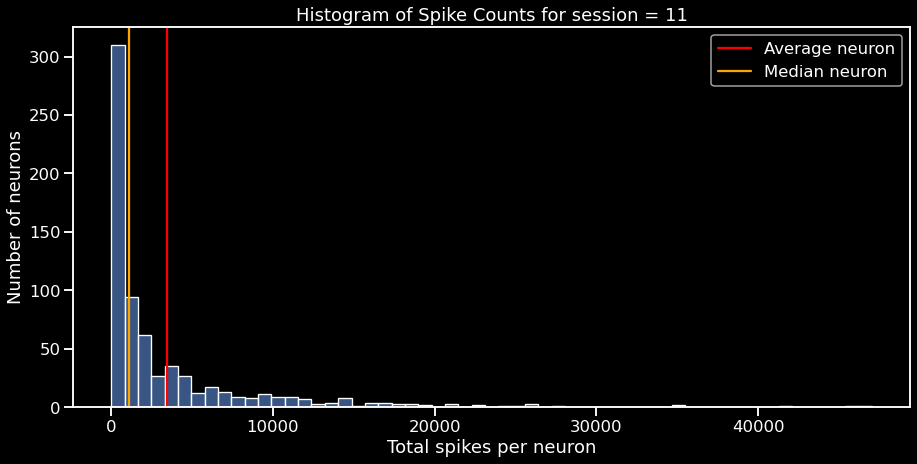

In [6]:
session_id = 11

plt.figure(figsize=(15,7))
sns.histplot(data=all_data[session_id]["spks"].sum(axis=(1, 2)))
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.title(f"Histogram of Spike Counts for session = {session_id}")
plt.axvline(np.mean(all_data[session_id]["spks"].sum(axis=(1, 2))), color="red", label="Average neuron")
plt.axvline(np.median(all_data[session_id]["spks"].sum(axis=(1, 2))), color="orange", label="Median neuron")
plt.legend()

### Spiking activity in a single trial (raster plot)

<Figure size 2160x720 with 0 Axes>

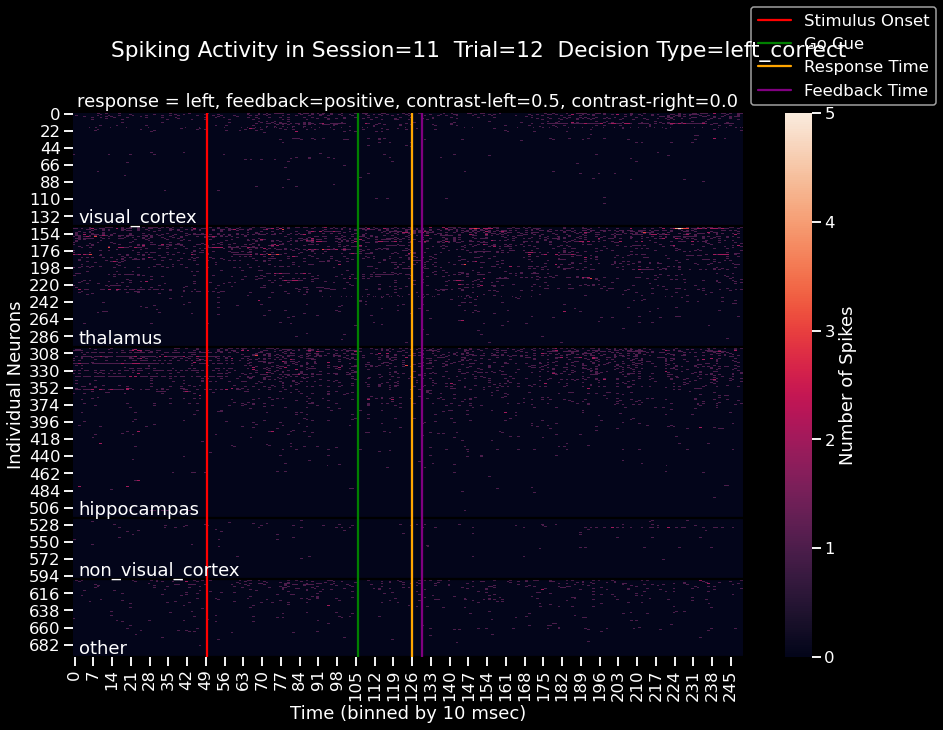

In [22]:
plot_spikes_raster(all_data=all_data, session_id=11, trial_id=12, cmap="rocket")

## Firing Rate

### Session

#### Average firing rate for a single session

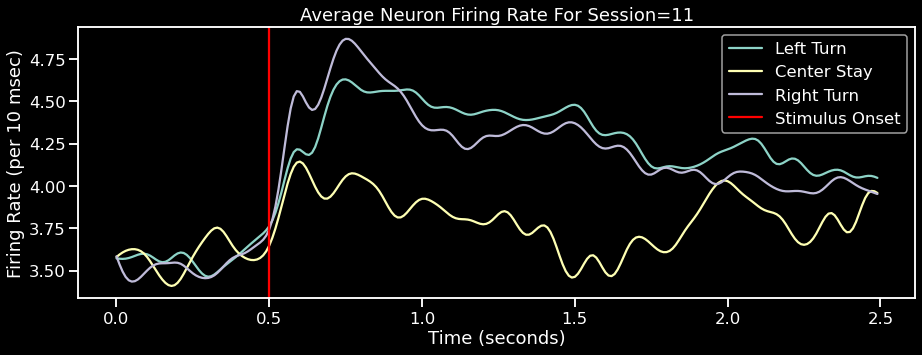

In [8]:
plot_firing_rate(all_data=all_data, session_id=11, trial_id=None, smooth=True, by_brain_regions=False)

#### Average firing rate for a single session filtered by brain region

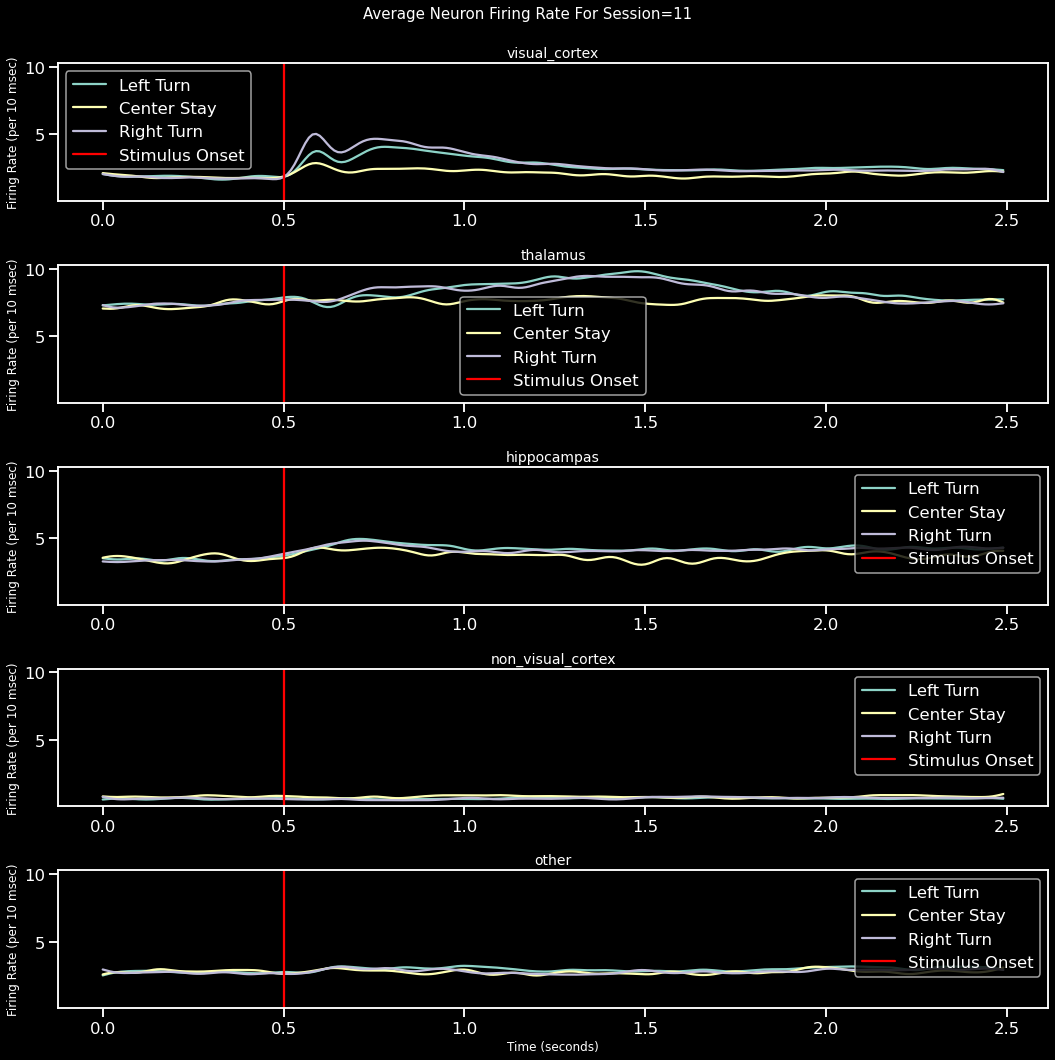

In [9]:
plot_firing_rate(all_data=all_data, session_id=11, trial_id=None, smooth=True, by_brain_regions=True)

### Trial

#### Average firing rate for a single trial

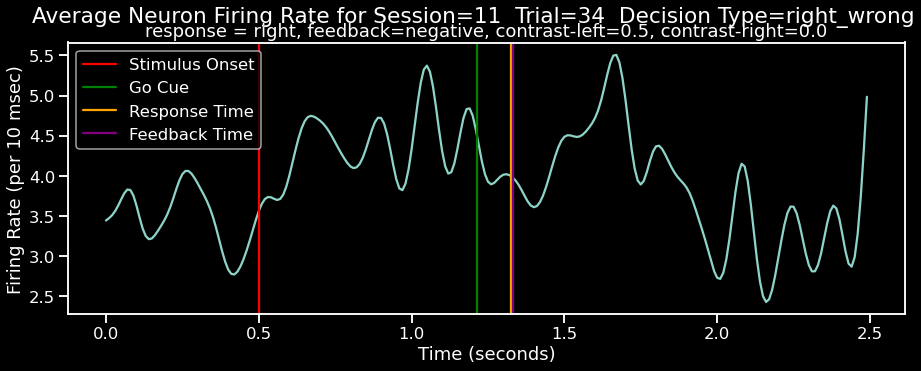

In [10]:
plot_firing_rate(all_data=all_data, session_id=11, trial_id=34, smooth=True, by_brain_regions=False)

#### Average firing rate for a single trial filtered by brain region

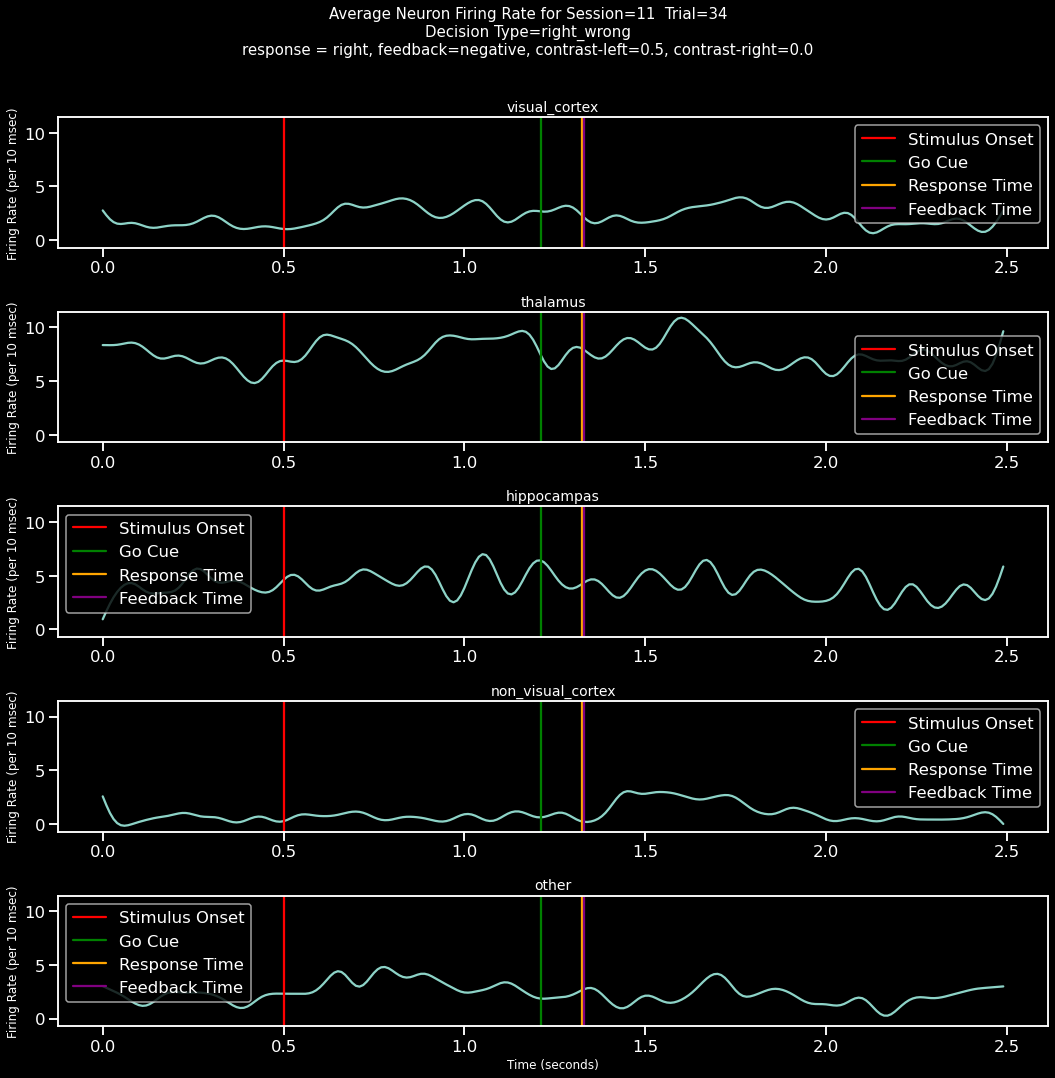

In [11]:
plot_firing_rate(all_data=all_data, session_id=11, trial_id=34, smooth=True, by_brain_regions=True)

## Dimensionality Reduction

In [12]:
session_id = 11

idx2response = {-1: "right", 0: "center", 1: "left"}
idx2feedback = {1: "positive", -1: "negative"}


viz_classes = {
    "responses": [idx2response[i] for i in all_data[session_id]["response"]],
    "feedbacks": [idx2feedback[i] for i in all_data[session_id]["feedback_type"]]
    
}

### Trials across Sessions

In [13]:
session_spikes = all_data[session_id]["spks"].mean(axis=2)
session_spikes.shape

(698, 340)

#### PCA

Explained variance is = [0.16599828 0.10539765]


<Figure size 1080x504 with 0 Axes>

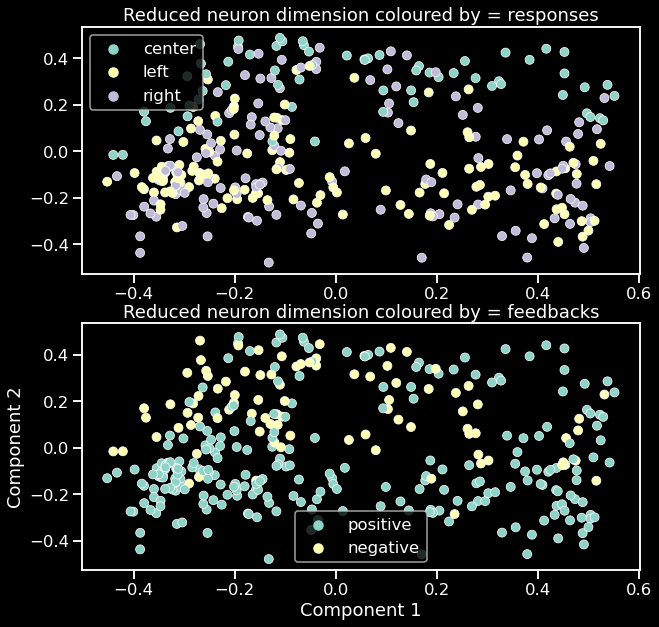

In [14]:
spikes_arr_pca = reduce_dimensionality(spikes_arr=session_spikes, 
                                       n_components=2, 
                                       algorithm="pca")

plot_components(spikes_arr=spikes_arr_pca, viz_classes=viz_classes)

#### TSNE

<Figure size 1080x504 with 0 Axes>

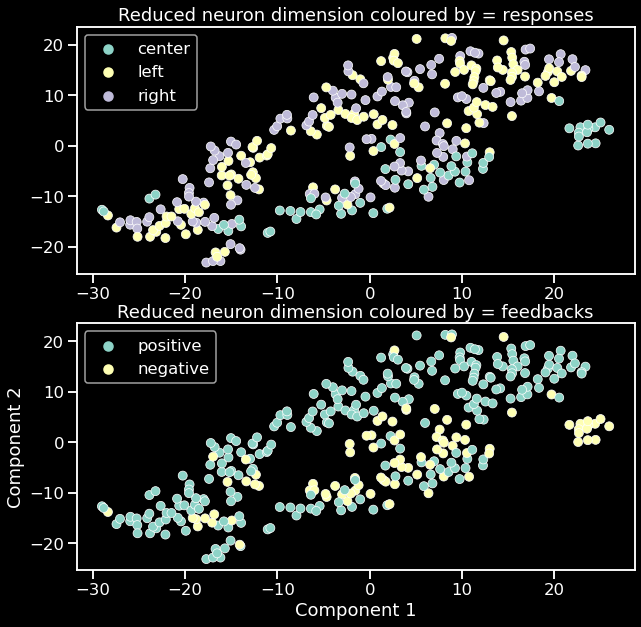

In [15]:
spikes_arr_tsne = reduce_dimensionality(spikes_arr=session_spikes, 
                                        n_components=2, 
                                        algorithm="tsne")

plot_components(spikes_arr=spikes_arr_tsne, viz_classes=viz_classes)

#### Factor Analysis

<Figure size 1080x504 with 0 Axes>

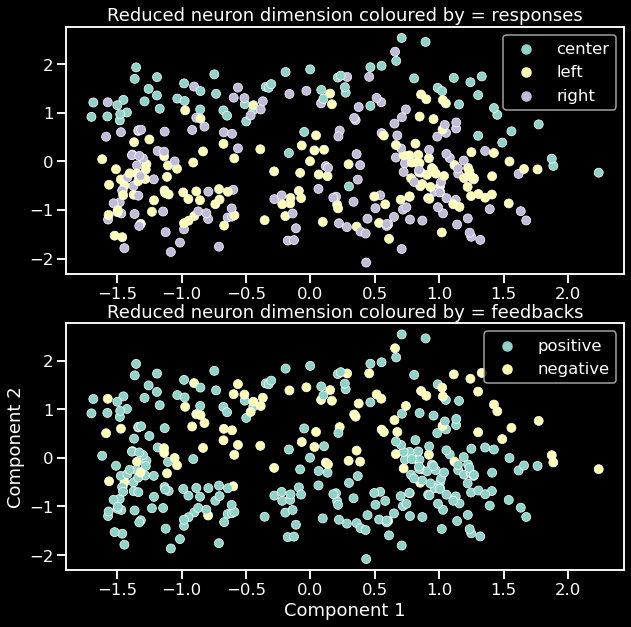

In [16]:
spikes_arr_fa = reduce_dimensionality(spikes_arr=session_spikes, 
                      n_components=2, 
                      algorithm="factor-analysis")

plot_components(spikes_arr=spikes_arr_fa, viz_classes=viz_classes)

#### Fact ICA

<Figure size 1080x504 with 0 Axes>

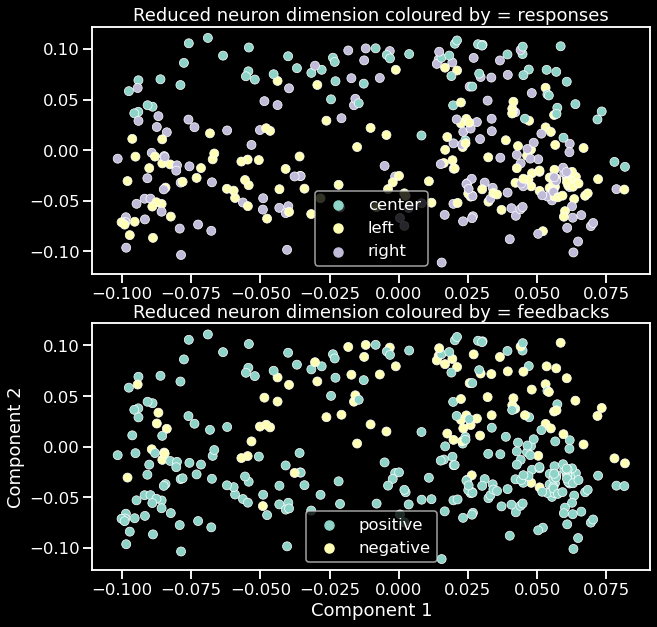

In [17]:
spikes_arr_ica = reduce_dimensionality(spikes_arr=session_spikes, 
                      n_components=2, 
                      algorithm="fast-ica")

plot_components(spikes_arr=spikes_arr_ica, viz_classes=viz_classes)